In [14]:
import os

def testFileLoading(folder):
    filesInFolder = os.listdir(folder)
    fileNames = [name for name in filesInFolder if name.startswith("Agent_")]

    for file in fileNames:
        print(file)

testFileLoading('Agents')

Agent_998243


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from problemStatementGenerator import *
from DataSaver import * 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model # for plotting model diagram

from keras import layers
from keras import optimizers
from keras.models import Sequential

In [16]:
# dataset, conditions = loadDataset('Agents/')

#### Building Initial Conditions

This function is for generating a random problem statment, since we do not really have a centralized dataset, this will just have to do for now as a proof of concept. That being said, what is listed here is important for us, and while these conditions will be stored offline somewhere, the process we will follow will more than likely be the same.

All the sub-function does, is unpack the conditions and the sub-arrays that are found within it, so it is no longer an object and just a straight array. We are going to use this array to generate our noise. Doing so will allow for a 'trackable' history. Each noise array will be generated by the parameters themselves. At the moment, it is possible to have collisions, but this method can be expanded upon to create a better 'key' system. For our purposes, it will do just fine.

In [17]:
YoungsModulusMax = 1e+12
YoungsModulusMin = 1e+9

CmaxRatio = 1e-5
CminRatio = 1e-3
ComplianceMinVal = 0

SmaxRatio = 1e+8
SminRatio = 1e+6
StressMinVal = 0

nelx, nely, nelz = 50, 100, 25

In [18]:
def generateProblem(nelx, nely):

    xDim, yDim = calcRatio(nelx, nely) # Length, Width

    c1, c2, c3, forces = FenicsCircleAndForceGenerator(xDim, yDim)
    Y, C_max, S_max = createConstraints(YoungsModulusMin,YoungsModulusMax,CmaxRatio,CminRatio,SmaxRatio,SminRatio)


    initial_conditions = [c1, c2, c3, forces, nelx, nely, Y, C_max, S_max]

    def unpackConditions(conditions):
        unpackedConditions = []

        circles = initial_conditions[:3]

        for x in range(3):
            for variable in circles[x]:
                unpackedConditions.append(variable)

            unpackedConditions.append(forces[0, x])
            unpackedConditions.append(forces[1, x])

        for x in range(4, len(conditions)):
            unpackedConditions.append(conditions[x])

        return unpackedConditions
    

    unpackedConditions = np.array(unpackConditions(initial_conditions))

    return unpackedConditions, initial_conditions

In [19]:
# np.random.seed(42)  # So the problem that is generated will always be the same. Comment this out for an actual random problem.
nelx, nely = 51, 101
unpacked, packed = generateProblem(nelx, nely)
unpackedTest = np.copy(unpacked)        # This will naturally be removed when ready for production

print("\nGenerated Problem:")
print(unpacked)
print(len(unpacked))
print(unpacked.shape)

c1, c2, c3 = packed[0], packed[1], packed[2]
forces = packed[3]
nelx, nely = packed[4], packed[5]
Y, C_max, S_max = packed[6], packed[7], packed[8]


Generated Problem:
[ 4.31000000e+00  2.53400000e+01  1.79476920e-01 -2.63646959e+03
 -6.57472056e+03  1.61100000e+01  3.73500000e+01  1.47575205e-01
 -5.54789123e+03 -4.95906618e+03  1.04000000e+00  7.47600000e+01
  1.17855312e-01  8.18436082e+03  1.15337867e+04  5.10000000e+01
  1.01000000e+02  6.16189159e+11  3.46370929e-04  6.19163214e+06]
20
(20,)


#### Creating Noise Array Based on Inital Conditions
The noise array is built off the initial conditions in 2 ways at first:
- Setting np.random.seed(x) where x:
    - x = abs(sum(cond))
- Size = (nelx, nely, len(unpacked))
    - unpacked is our conditions array, so the number of elements dictates our starting depth. Each layer within the noise array however, is a random value of (1-255), dictated by our .seed(x) value. So it's partially determined, partially random.

616195351155.9891
61619535115.598915
6161953511.559892
616195351.1559892
(51, 101, 20)


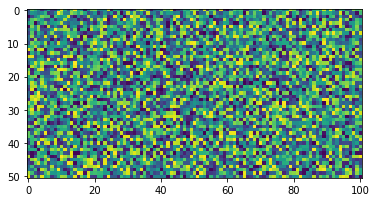

In [20]:
newSeed = np.sum(unpacked)
print(newSeed)

while newSeed > (2**32 - 1):
    newSeed /= 10
    print(newSeed)
    
newSeed = np.abs(int(newSeed)) 

np.random.seed(newSeed)

noise = np.random.randint(1, 256, size=(nelx, nely, len(unpacked)))
print(noise.shape)
plt.imshow(noise[:, :, 0])

## Model Building

### Generator
The generator is a split model, such that it takes in the problem discription and the noise array and then merges to pass through several convolutional layers.
Having the split for different inputs gives us the ability to actually guide our generator, which is _exactly_ what we want.

This first generator is simply a framework to build variations off of. Simple, and flexible.

In [21]:
# Very simple Generator model framework (make changes off of this(?))
def generator():
    # Label inputs of model, this will hold (roughly) true for every architecture
    label_input = layers.Input(shape=unpacked.shape, name='Label-Input')
    
    # CNN param to resize to
    shape_0, shape_1 = nelx, nely
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes, name='Label-Dense')(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1), name='Label-Reshape')(labels)


    # Update to n_nodes to match Gen branch
    n_nodes *= 20

    # Generator noise array input model
    noise_input = layers.Input(shape=(nelx, nely, len(unpacked)), name='Noise-Input')   # 50, 100, 20    


    merge = layers.Concatenate()([noise_input, labels])
    resize = layers.Resizing(height=128, width=64)(merge)


    # Layer 1
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same')(resize)
    gen = layers.ReLU()(gen)

    # Layer 2
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(1,1),
                                padding='same')(gen)
    gen = layers.ReLU()(gen)
    gen = layers.MaxPool2D(pool_size=(2,2))(gen)

    # Output & Model object
    output = layers.Conv2D(filters=1, kernel_size=(7,7), activation='tanh',
                           padding='same')(gen)
    output = layers.Resizing(height=nelx, width=nely)(output)

    model = keras.models.Model([noise_input, label_input], output)
    
    return model

In [22]:
gen1 = generator()
gen1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label-Input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 Label-Dense (Dense)            (None, 5151)         108171      ['Label-Input[0][0]']            
                                                                                                  
 Noise-Input (InputLayer)       [(None, 51, 101, 20  0           []                               
                                )]                                                                
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Dense[0][0]']        

2023-03-19 23:24:05.628637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Discriminator

Our Discriminator is also a split model. Most of the architecture will follow sorta an inverse of the discriminator, at least in terms of resolutions. While our generator creates images that end as 100x50xD (where D is the depth), our discriminator takes in images at that resolution and results in a simple classification node.

In [23]:
def discriminator():

    label_input = layers.Input(shape=unpacked.shape)

    # CNN param to resize to
    shape_0, shape_1 = nelx, nely
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes, name='Label-Input')(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1), name='Label-Reshape')(labels)

    # This is our input from the image
    image_input = layers.Input(shape=(nelx, nely, 1), name='Image-Input')


    merge = layers.Concatenate()([labels, image_input])

    # These next few upscale layers are here so when we resize to 128x64,
    # (ideally) more information is preserved and not lost through the resizing operation
    upscale = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same', name='Upscale-1')(merge)
    upscale = layers.ReLU(name='Upscale-1-ReLU')(upscale)

    upscale = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same', name='Upscale-2')(upscale)
    upscale = layers.ReLU(name='Upscale-2-ReLU')(upscale)


    resize = layers.Resizing(height=128, width=64)(upscale)


    dis = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Conv-1')(resize)
    dis = layers.LeakyReLU(alpha=0.2, name='ReLU-1')(dis)


    dis = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Conv-2')(dis)
    dis = layers.LeakyReLU(alpha=0.2, name='ReLU-2')(dis)
    dis = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='MaxPool-1')(dis)


    dis = layers.Flatten()(dis)
    dis = layers.Dropout(0.2)(dis)


    output = layers.Dense(1, activation='sigmoid')(dis)
    # output = layers.Softmax()(output)


    model = keras.models.Model([image_input, label_input], output)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  metrics=['accuracy'])
    
    return model




In [24]:
dis1 = discriminator()
dis1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 Label-Input (Dense)            (None, 5151)         108171      ['input_1[0][0]']                
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Input[0][0]']            
                                                                                                  
 Image-Input (InputLayer)       [(None, 51, 101, 1)  0           []                               
                                ]                                                           

In [25]:
# Data preparation. This is kept separate so these do not 
# continuously reshape and mess up their dimensions
unpacked = np.reshape(unpacked, newshape=(1, 20))
noise = np.reshape(noise, newshape=((1,) + noise.shape))

In [26]:
print("Generator Input and Output")
print("Input: ", gen1.input)
print("Output: ", gen1.output)

gen_predict = gen1((noise, unpacked), training=False)
# print(gen_predict)
print(gen_predict.shape)

# print("\nGenerator Image Output:")
# plt.imshow(gen_predict[0, :, :, 0])
# plt.show()

print("\n\nDiscriminator Input and Output")
print("Input: ", dis1.input)
print("Output: ", dis1.output)

dis_predict = dis1((gen_predict, unpacked), training=False)
print(dis_predict)


Generator Input and Output
Input:  [<KerasTensor: shape=(None, 51, 101, 20) dtype=float32 (created by layer 'Noise-Input')>, <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'Label-Input')>]
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 51, 101, 1), dtype=tf.float32, name=None), name='resizing_1/resize/ResizeBilinear:0', description="created by layer 'resizing_1'")
(1, 51, 101, 1)


Discriminator Input and Output
Input:  [<KerasTensor: shape=(None, 51, 101, 1) dtype=float32 (created by layer 'Image-Input')>, <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'input_1')>]
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


### Merging of Generator and Discriminator into a full "cDCGAN"

Here we are putting both sub-models together into one full model, essentially.
Luckily, this function is a very plug-in, shit-out, function. So our generator and discriminator are defined outside and then put together. 

**_Meaning:...._** 
##### OUR GANs CAN BE COMPOSED OF MANY DIFFERENT GENERATORS AND DISCRIMINIATORS
So in reality, we need to be creating and trying different combinations of models. Perhaps one combination performs far better than another. It will also be worth figurein

In [27]:
def full_gan(gen, dis):
    dis.trainable = False

    gen_noise, gen_label = gen.input
    gen_output = gen.output

    gan_output = dis([gen_output, gen_label])

    model = keras.models.Model([gen_noise, gen_label], gan_output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    
    return model

In [28]:
gan_model_1 = full_gan(gen1, dis1)
gan_model_1.summary()

plot_model(gan_model_1, show_shapes=True, show_layer_names=True, dpi=400, to_file='/pics/dcgan_structure.png')


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label-Input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 Label-Dense (Dense)            (None, 5151)         108171      ['Label-Input[0][0]']            
                                                                                                  
 Noise-Input (InputLayer)       [(None, 51, 101, 20  0           []                               
                                )]                                                                
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Dense[0][0]']      

In [29]:
gan_model_output = gan_model_1((noise, unpacked), training=False)
print(gan_model_output)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


In [30]:
x = np.random.rand(nelx * nely* len(unpacked))
x = np.reshape(x, newshape=(nelx, nely, len(unpacked)))

# print(x)
print(len(x))
print(x.shape)
print(nelx * nely* len(unpacked))


51
(51, 101, 1)
5151


### Side Functions:

The next few functions are here for the quick and easy creation of real_ or fake_samples, condition vectors, and noise vectors (using the generated condition vectors).

In [32]:
def createConditionsArray(numConditions):
    conditions = []

    for x in range(numConditions):
        unpacked, _ = generateProblem(nelx, nely)
        conditions.append(unpacked)

    conditions = np.array(conditions)
    
    return conditions

conditionArray = createConditionsArray(100)

In [33]:
def generateNoise(unpacked, rng):
    newSeed = np.sum(unpacked)
    # print(newSeed)

    while newSeed > (2**32 - 1):
        newSeed /= 10
        # print(newSeed)
        
    newSeed = np.abs(int(newSeed)) 

    # noise = np.random.randint(1, 256, size=(nelx, nely, len(unpacked)))
    noise = rng.standard_normal(size=(nelx, nely, len(unpacked)))
    # print('Len', len(unpacked))
    # print(noise.shape)
    # plt.imshow(noise[:, :, 0])

    return noise

def createNoiseVector(conditions, numSamples, rng):
    noiseVector = []

    for x in range(numSamples):
        noise = generateNoise(conditions[x], rng)
        noiseVector.append(noise)

    return np.array(noiseVector)


rng = np.random.default_rng(newSeed)

newNoise = generateNoise(unpackedTest, rng)

noiseArray = createNoiseVector(conditionArray, 100, rng)

print(noiseArray.shape)

(100, 51, 101, 20)


In [34]:
def real_samples(dataset, conditions, numSamples, rng):
    index_samples = rng.standard_normal(0, dataset.shape[0], numSamples)

    X, xCondtions = dataset[index_samples], conditions[index_samples]

    y = np.ones((numSamples, 1))

    return [X, xCondtions], Y


def fake_samples(gen, numSamples, rng):
    gen_preds, xConditions = [], []

    for x in range(numSamples):
        fakeCondition, _ = generateProblem()

        xNoise = generateNoise(fakeCondition, rng)
        gen_prediction = gen((xNoise, fakeCondition), training=False)

        gen_preds.append(gen_prediction)
        xConditions.append(fakeCondition)

    y = np.zeros((numSamples, 1))

    return [gen_preds, xConditions], y    

### Our Training Driver

In [35]:
def train(gen, dis, gan_model, dataset, conditions, rng, n_epochs=10, n_batch=128, n_eval=200):
    batch_per_epoch = int(dataset.shape[0] / n_batch)

    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            [X_real, cond_real], y_real = real_samples(dataset, conditions, half_batch, rng)
            dis_loss1, _ = dis.train_on_batch([X_real, cond_real], y_real)

            [X_fake, cond_fake], y_fake = fake_samples(gen, conditions, half_batch, rng)
            dis_loss2, _ = dis.train_on_batch([X_fake, cond_fake], y_fake)

            randConditions = createConditionsArray(n_batch)
            noiseArray = createNoiseVector(randConditions, n_batch, rng)
            y_gan = np.ones((n_batch, 1))

            generator_loss = gan_model.train_on_batch([noiseArray, randConditions], y_gan)

            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f, Gen_Loss=%.3f' %
                    (i+1, j+1, batch_per_epoch, dis_loss1, dis_loss2, generator_loss))
